In [1]:
# Last mod: FA 2023 Aug 21 - joined the predictions from this run with outputs of train_xgboost_miglio2021_quantileregression.ipynb

# Predicting ages from spectroscopic abundances with XGBoost 

In [2]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib import colors

import astropy.table
from astropy.table import Table, Column, MaskedColumn 
from scipy.stats import gaussian_kde
from scipy.interpolate import make_interp_spline

import os.path

from time import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

import xgboost as xgb
import shap

from itertools import product
import pickle
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from utils import running_median, overplot_trend

mpl.rc('xtick', labelsize=15) 
mpl.rc('ytick', labelsize=15) 
font = {'family' : 'serif', 'serif': 'helvet', 'weight' : 'bold', 'size'   : 20}
mpl.rc('font', **font)
mpl.rc('text', usetex=True)

In [3]:
suffix = "_230414" # date of initial run

In [4]:
xgb.__version__

'1.7.6'

# Import the training table (APOGEE-Kepler dataset)

We use the table containing asteroseismic+spectroscopic age estimates from [Miglio et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021A%26A...645A..85M/abstract) - crossmatched with APOGEE DR17:

In [5]:
miglio2021 = Table.read("../data/Miglio2021_X_APOGEE_DR17.fits")
names = [name for name in miglio2021.colnames if len(miglio2021[name].shape) <= 1]
miglio2021.keep_columns(names)
mig = miglio2021.to_pandas()
mig.head()

,APOGEE,KIC,Jmag,Hmag,Ksmag,RAdeg,DEdeg,__Fe_H_,__alpha_M_,Age,...,NI_FE_ERR,NI_FE_FLAG,CU_FE,CU_FE_SPEC,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG
0,b'2M19222920+3710285',1569842,9.589,9.074,8.989,290.6217,37.174599,-0.24,0.12,9.8,...,0.012334,0,NaN,NaN,0.005112,2,0.096240,0.151900,0.069591,0
1,b'2M19300513+3717470',1726291,11.206,10.679,10.547,292.5214,37.296398,-0.34,0.19,10.1,...,0.015864,0,NaN,NaN,0.009413,2,-0.318970,-0.263310,0.085400,0
2,b'2M19045380+3741230',2283721,11.266,10.709,10.590,286.2242,37.689701,-0.19,0.11,9.4,...,0.014437,0,NaN,NaN,NaN,259,0.116419,0.172079,0.077468,0
3,b'2M19060736+3740100',2284679,9.923,9.456,9.335,286.5307,37.669399,-0.45,0.21,11.2,...,0.014171,0,NaN,NaN,0.010622,2,-0.313170,-0.257510,0.076819,0
4,b'2M19280882+3736381',2305590,9.829,9.235,9.128,292.0368,37.610600,-0.30,0.24,10.2,...,0.018914,0,NaN,NaN,0.009991,258,0.581840,0.637500,0.082008,0


In [6]:
list(mig.columns)

['APOGEE',
 'KIC',
 'Jmag',
 'Hmag',
 'Ksmag',
 'RAdeg',
 'DEdeg',
 '__Fe_H_',
 '__alpha_M_',
 'Age',
 'b_Age',
 'b_age_lc',
 'Mass',
 'b_Mass',
 'b_mass_lc',
 'Rad',
 'b_Rad',
 'b_rad_lc',
 'Dist',
 'b_Dist',
 'b_dist_lc',
 'Av',
 'b_Av',
 'b_av_lc',
 'evstate',
 'zmax',
 'e_zmax',
 'Ecc',
 'e_Ecc',
 'Rperi',
 'e_Rperi',
 'Rap',
 'e_Rap',
 'GalR',
 'Galphi',
 'GalZ',
 'vR',
 'vT',
 'vZ',
 '_RA',
 '_DE',
 'APOGEE_ID',
 'TELESCOPE',
 'FIELD',
 'ALT_ID',
 'RA',
 'DEC',
 'GLON',
 'GLAT',
 'J',
 'J_ERR',
 'H',
 'H_ERR',
 'K',
 'K_ERR',
 'AK_TARG',
 'AK_TARG_METHOD',
 'AK_WISE',
 'SFD_EBV',
 'APOGEE_TARGET1',
 'APOGEE_TARGET2',
 'APOGEE2_TARGET1',
 'APOGEE2_TARGET2',
 'APOGEE2_TARGET3',
 'APOGEE2_TARGET4',
 'TARGFLAGS',
 'SURVEY',
 'PROGRAMNAME',
 'NVISITS',
 'SNR',
 'SNREV',
 'STARFLAG',
 'STARFLAGS',
 'ANDFLAG',
 'ANDFLAGS',
 'VHELIO_AVG',
 'VSCATTER',
 'VERR',
 'RV_TEFF',
 'RV_LOGG',
 'RV_FEH',
 'RV_ALPHA',
 'RV_CARB',
 'RV_CHI2',
 'RV_CCFWHM',
 'RV_AUTOFWHM',
 'RV_FLAG',
 'N_COMPONENTS'

There is also a column informing about the evolutionary state (RC / RGB):

In [7]:
print("RGB stars:", np.sum(mig['evstate']==1))
print("RC  stars:", np.sum(mig['evstate']==2))
print("unidentified:", np.sum((mig['evstate']!=1) & (mig['evstate']!=2)))

RGB stars: 2428
RC  stars: 887
unidentified: 0


We'll also have a look at the APOGEE DR17 abundance flags:

In [8]:
for columns in mig:
    if columns.endswith("_FLAG"):
        print(columns)
        print(mig[str(columns)].value_counts())
        print()

RV_FLAG
0     3314
32       1
Name: RV_FLAG, dtype: int64

C_FE_FLAG
0      3314
256       1
Name: C_FE_FLAG, dtype: int64

CI_FE_FLAG
0      3312
256       3
Name: CI_FE_FLAG, dtype: int64

N_FE_FLAG
0      3272
256      37
288       6
Name: N_FE_FLAG, dtype: int64

O_FE_FLAG
0    3315
Name: O_FE_FLAG, dtype: int64

NA_FE_FLAG
0      3311
256       3
1         1
Name: NA_FE_FLAG, dtype: int64

MG_FE_FLAG
0    3315
Name: MG_FE_FLAG, dtype: int64

AL_FE_FLAG
0    3315
Name: AL_FE_FLAG, dtype: int64

SI_FE_FLAG
0    3315
Name: SI_FE_FLAG, dtype: int64

P_FE_FLAG
2      3270
258      30
0         8
3         4
259       3
Name: P_FE_FLAG, dtype: int64

S_FE_FLAG
0      3314
256       1
Name: S_FE_FLAG, dtype: int64

K_FE_FLAG
0      3313
1         1
256       1
Name: K_FE_FLAG, dtype: int64

CA_FE_FLAG
0    3315
Name: CA_FE_FLAG, dtype: int64

TI_FE_FLAG
0    3315
Name: TI_FE_FLAG, dtype: int64

TIII_FE_FLAG
0      3307
257       4
256       3
1         1
Name: TIII_FE_FLAG, dtype: int64


## Data selection criteria

Looking at the FLAG values above, we decide not to use [P/Fe] and [Cu/Fe].
For all other abundances, we require the corresponding FLAG to equal zero:

In [9]:
mig = mig[(mig['RV_FLAG'] == 0)   & (mig['C_FE_FLAG'] == 0)   & \
          (mig['CI_FE_FLAG'] == 0)& (mig['N_FE_FLAG'] == 0)   & \
          (mig['O_FE_FLAG'] == 0) & (mig['NA_FE_FLAG'] == 0)  & \
          (mig['S_FE_FLAG'] == 0) & (mig['TI_FE_FLAG'] == 0)  & \
          (mig['V_FE_FLAG'] == 0) & (mig['CE_FE_FLAG'] == 0)  & \
          (mig['SNREV'] >= 70) & \
          (0.5 * (mig['b_age_lc'] - mig['b_Age']) / mig["Age"] < 0.3) & \
          (0.5 * (mig['b_age_lc'] - mig['b_Age']) < 3) & \
          (mig["Age"] > 0)    & (mig["Age"] < 15) & \
          (mig["ALPHA_M"] < 0.14 + 0.0001*(mig["Age"] - 4.1)**5)
         ]

In [10]:
print(len(mig), "suffice the FLAG conditions")

3060 suffice the FLAG conditions


(array([  2.,   5.,  20., 135., 366., 616., 891., 710., 262.,  53.]),
 array([-0.94691998, -0.80627298, -0.66562599, -0.524979  , -0.384332  ,
        -0.24368499, -0.103038  ,  0.037609  ,  0.17825601,  0.318903  ,
         0.45954999]),
 <BarContainer object of 10 artists>)

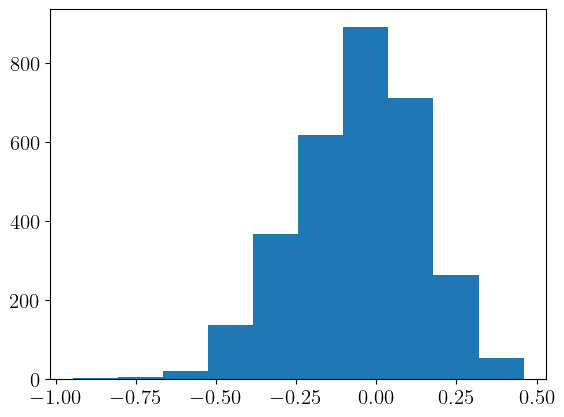

In [11]:
plt.hist(mig["FE_H"])

## Some plots (overplotting the training set over the full APOGEE DR17 data):

The APOGEE DR17 allStar file is big, so it's not included in the data folder. Even the "light" version is 1.7 GB:
* Data model: https://data.sdss.org/datamodel/files/APOGEE_ASPCAP/APRED_VERS/ASPCAP_VERS/allStar.html
* "Lite" file for download: https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStarLite-dr17-synspec_rev1.fits

The following cell reads the DR17 table:

In [12]:
apogee_data = "../data/allStarLite-dr17-synspec_rev1.fits"

if os.path.exists(apogee_data):
    pass
else:
    # Download the APOGEE DR17 "lite" version: (this can take a while...)
    os.system('wget https://data.sdss.org/sas/dr17/apogee/spectro/aspcap/dr17/synspec_rev1/allStarLite-dr17-synspec_rev1.fits')
    os.system('mv allStarLite-dr17-synspec_rev1.fits ../data/.')

# Read and convert to pandas
apogee_dr17 = Table.read(apogee_data)
names = [name for name in apogee_dr17.colnames if len(apogee_dr17[name].shape) <= 1]
apogee_dr17.keep_columns(names)
big   = apogee_dr17.to_pandas()

print('Number of rows: ' +str(len(big)))
big.head()

Number of rows: 733901


,APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,...,NI_FE_ERR,NI_FE_FLAG,CU_FE,CU_FE_SPEC,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG
0,b'VESTA',b'apo1m',b'calibration',b' ',NaN,NaN,292.219131,-30.602919,99.999001,0.000,...,0.010266,0,NaN,NaN,0.059403,2,NaN,NaN,NaN,64
1,b'2M00000002+7417074',b'apo25m',b'120+12',b'none',0.000103,74.285408,119.401807,11.767414,8.597000,0.039,...,0.010609,0,NaN,NaN,0.001221,2,NaN,NaN,NaN,64
2,b'2M00000019-1924498',b'apo25m',b'060-75',b'none',0.000832,-19.413851,63.394122,-75.906397,11.074000,0.022,...,0.013835,0,NaN,NaN,0.102594,2,NaN,NaN,NaN,64
3,b'2M00000032+5737103',b'apo25m',b'116-04',b'none',0.001335,57.619530,116.065371,-4.564768,10.905000,0.023,...,0.016555,0,NaN,NaN,0.123839,2,NaN,NaN,NaN,64
4,b'2M00000032+5737103',b'apo25m',b'N7789',b'none',0.001335,57.619530,116.065371,-4.564768,10.905000,0.023,...,0.012638,0,NaN,NaN,0.107103,2,NaN,NaN,NaN,64


Define the same selection as for the training set:

In [13]:
# Cut out stars on the RGB close to the training set
kielbox =  (big['LOGG'] < 3.4)  & (big['LOGG'] > 2.2) & (big['TEFF'] < 5200) & (big['TEFF'] > 4400)
# IF you want to be more restrictive, add:
# & (big['LOGG'] < -7 + 0.0022*big['TEFF'])  & (big['LOGG'] > -8.6 + 0.0022*big['TEFF'])

selection = kielbox  & \
            (big['FE_H'] > -1)      & (big['SNREV'] >= 50)    & \
            (big['TEFF_ERR'] < 150) & (big['RV_FLAG'] == 0)   & \
            (big['C_FE_FLAG'] == 0) & (big['N_FE_FLAG'] == 0) & \
            (big['CI_FE_FLAG'] == 0)& (big['O_FE_FLAG'] == 0) & \
            (big['SI_FE_FLAG'] == 0)& (big['TI_FE_FLAG'] == 0)& \
            (big['CA_FE_FLAG'] == 0)& (big['AL_FE_FLAG'] == 0)& \
            (big['CO_FE_FLAG'] == 0)& (big['NI_FE_FLAG'] == 0)& \
            (big['MN_FE_FLAG'] == 0)& (big['CE_FE_FLAG'] == 0)

print(np.sum(selection), "stars with good quality")

193886 stars with good quality


### $T_{\rm eff}-\log g$ diagram

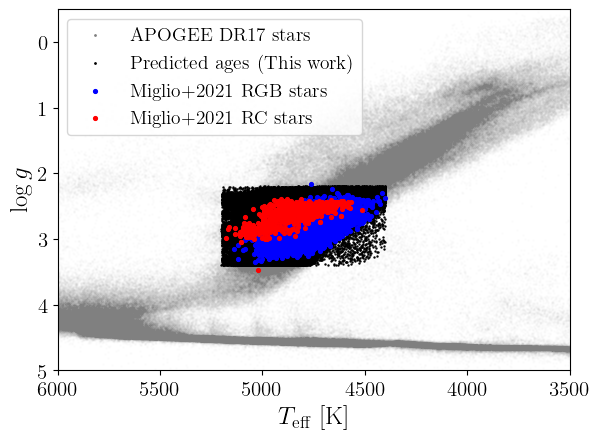

In [14]:
rgb = (mig['evstate']==1)
rc  = (mig['evstate']==2)

plt.scatter(big['TEFF'], big['LOGG'], c="grey", alpha=0.01, s=1, label="_nolabel")
plt.scatter(-999, -999, c="grey", alpha=1, s=1, label="APOGEE DR17 stars")
plt.scatter(big['TEFF'][selection], big['LOGG'][selection], c="k", s=.5, label="_nolabel")
plt.scatter(-999, -999, c="k", alpha=1, s=1, label="Predicted ages (This work)")
plt.scatter(mig['TEFF'][rgb], mig['LOGG'][rgb], s=7.5, c="b", label="Miglio+2021 RGB stars")
plt.scatter(mig['TEFF'][rc],  mig['LOGG'][rc],  s=7.5, c="red", label="Miglio+2021 RC stars")
plt.axis([6000, 3500, 5, -0.5])
plt.xlabel(r"$T_{\rm eff}$ [K]", fontsize=18)
plt.ylabel(r"$\log g$", fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.tight_layout()
plt.savefig("../im/kiel_diagram.png", dpi=300)

### Age uncertainties of the Miglio+2021 sample

Median rel. age uncertainty for RGB: 0.22727272
Median rel. age uncertainty for RC: 0.097561


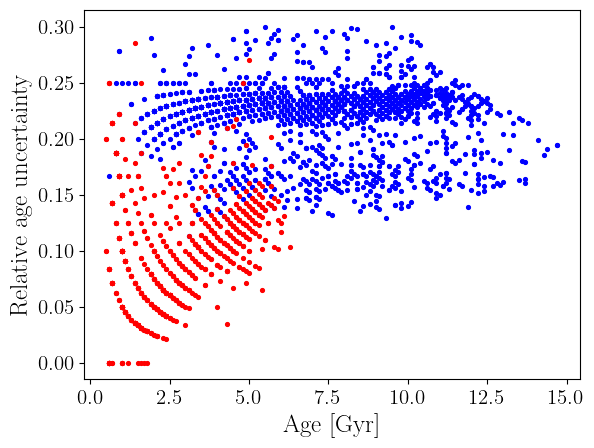

In [15]:
x = mig['Age']
y = 0.5 * (mig['b_age_lc'] - mig['b_Age']) / mig["Age"]

plt.scatter(x[rgb],y[rgb], c="b", s=7.5)
plt.scatter(x[rc], y[rc],  c="r", s=7.5)

plt.xlabel(r"Age [Gyr]", fontsize=18)
plt.ylabel(r"Relative age uncertainty", fontsize=18)
plt.savefig("../im/age_uncerts_training.png", dpi=300)

print("Median rel. age uncertainty for RGB:", np.nanmedian(y[rgb]))
print("Median rel. age uncertainty for RC:", np.nanmedian(y[rc]))
      

## Galactic distribution

In [16]:
dr17_master = Table.read("/home/friedel/Astro/Spectro/APOGEE/data/DR17/APOGEE_DR17_MASTER_Mar2023.fits")
chem_age = np.isfinite(dr17_master['spec_age_230314'])

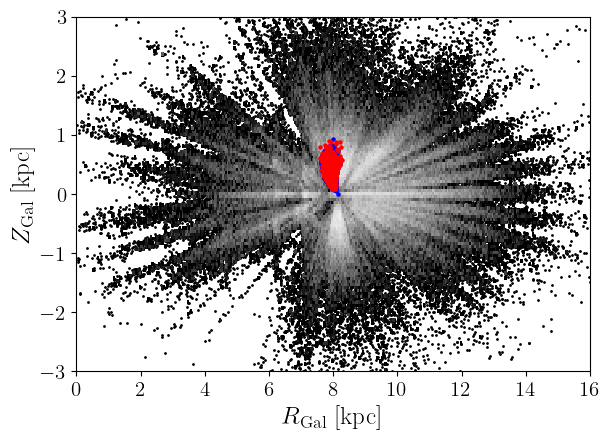

In [17]:
plt.scatter(dr17_master['Rg'][chem_age], dr17_master['Zg'][chem_age], c="k", s=1, alpha=1, label="APOGEE DR17")
Ht,X1,X2 = np.histogram2d(dr17_master['Rg'][chem_age], dr17_master['Zg'][chem_age], 
                          bins=[320,120], range=[[0, 16], [-3, 3]])
Ht[Ht<2] = np.nan
image = plt.pcolor(0.5*(X1[:-1]+X1[1:]), 0.5*(X2[:-1]+X2[1:]), Ht.T, cmap="Greys_r", 
                   label=r"APOGEE DR17 giants", norm=colors.LogNorm())
plt.scatter(mig['GalR'][rgb], mig['GalZ'][rgb], s=5, c="b", label="Miglio+2021 RGB stars")
plt.scatter(mig['GalR'][rc],  mig['GalZ'][rc],  s=5, c="red", label="Miglio+2021 RC stars")
plt.axis([0, 16, -3, 3])
plt.xlabel(r"$R_{\rm Gal}$ [kpc]", fontsize=18)
plt.ylabel(r"$Z_{\rm Gal}$ [kpc]", fontsize=18)
plt.tight_layout()
plt.savefig("../im/RZ_training_vs_all.png", dpi=300)

# Create the actual training set

Now we create a pandas dataframe containing only the columns we think could be interesting to use in the training:

In [18]:
trainfeatures = ['TEFF', 'LOGG', 'C_FE', 'CI_FE', 'N_FE', 'O_FE', 
                 'NA_FE', 'MG_FE', 'AL_FE', 'SI_FE', 'K_FE', 
                 'CA_FE', 'TI_FE', 'V_FE', 'MN_FE', 'CO_FE', 'NI_FE', 'CE_FE']
filtered_df = mig[['Age'] + trainfeatures].copy() # excluding: ['FE_H']
filtered_df = filtered_df.dropna()
filtered_df = filtered_df.apply(pd.to_numeric, errors='coerce')

In [19]:
filtered_df.head()

,Age,TEFF,LOGG,C_FE,CI_FE,N_FE,O_FE,NA_FE,MG_FE,AL_FE,SI_FE,K_FE,CA_FE,TI_FE,V_FE,MN_FE,CO_FE,NI_FE,CE_FE
0,9.8,4817.990723,3.083905,0.071996,0.076009,0.073346,0.196913,-0.129988,0.223263,0.188314,0.134081,0.235769,0.094765,0.179623,-0.042288,-0.101498,0.09864,0.107133,0.096240
1,10.1,4823.796387,3.109932,0.070293,0.194000,0.115990,0.314393,-0.352128,0.348673,0.259540,0.198561,0.302629,0.190765,0.151823,0.250612,-0.122728,0.13715,0.110182,-0.318970
2,9.4,4748.026855,2.788529,0.065446,0.029532,0.086760,0.180403,0.009112,0.186943,0.195936,0.124651,0.368155,0.109715,0.109363,-0.187218,-0.096728,0.11898,0.042022,0.116419
3,11.2,4889.548828,3.245908,0.102185,0.198900,0.009152,0.328173,0.068522,0.361593,0.247761,0.191911,0.361549,0.191585,0.183673,-0.175608,-0.144048,0.08713,0.081733,-0.313170
4,10.2,4605.007812,2.480893,0.166720,0.234920,0.034750,0.282853,0.043942,0.394983,0.272437,0.166551,0.411468,0.190875,0.281993,-0.025298,-0.137478,0.19849,0.095583,0.581840


In [20]:
# Split dataframe into input and output columns
y = filtered_df['Age']
X = filtered_df.drop(columns = 'Age')

# Splitting into train and test (80% vs 20%)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Train XGBoost

Test if the algorithm works - this should be really fast:

In [21]:
filename = './models/test_model'+suffix+'.pkl'

if os.path.exists(filename):
    # Read the trained model from disk:
    model = pickle.load(open(filename, 'rb'))
else:
    # Instantiation
    model = xgb.XGBRegressor(objective ='reg:squarederror',
                             n_estimators = 500, seed = 123)
    # Fit the model
    model.fit(train_X, train_y)
    # Save the model
    pickle.dump(model, open(filename, 'wb'))

# Predict the model
pred = model.predict(test_X)
  
# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))

#Score
result = model.score(test_X, test_y)
print("Score: "+str(result))

[11:04:35] WARNING: ../src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

RMSE :  1.176810
Score: 0.8489176985384856


### Run gridsearch to optimise the hyperparameters:
Running the following cell takes a while (~30 min on an 8-core computer with 16GB RAM)... so it's not recommended to run it unless you really need it.

If you have actually run the hyperparameter optimisation, you should have gotten this result:

In [22]:
best_params = {'learning_rate': 0.005,
              'max_depth': 7,
              'min_child_weight': 10,
              'n_estimators': 1500,
              'nthread': 4,
              'objective': 'reg:squarederror',
              'subsample': 0.6}

### Run the algorithm with optised hyperparameters:

In [23]:
filename = './models/default_model_'+suffix+'.pkl'

if os.path.exists(filename):
    # Read the trained model from disk:
    model = pickle.load(open(filename, 'rb'))
else:
    # Instantiation
    model = xgb.XGBRegressor(**best_params, seed = 123)
    # Fit the model
    model.fit(train_X, train_y)
    # Save the model
    pickle.dump(model, open(filename, 'wb'))

# Predict the model
pred = model.predict(test_X)
  
# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))

#Score
result = model.score(test_X, test_y)
print("Score: "+str(result))

[11:04:35] WARNING: ../src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

RMSE :  1.064779
Score: 0.8763141916547467


# Plots

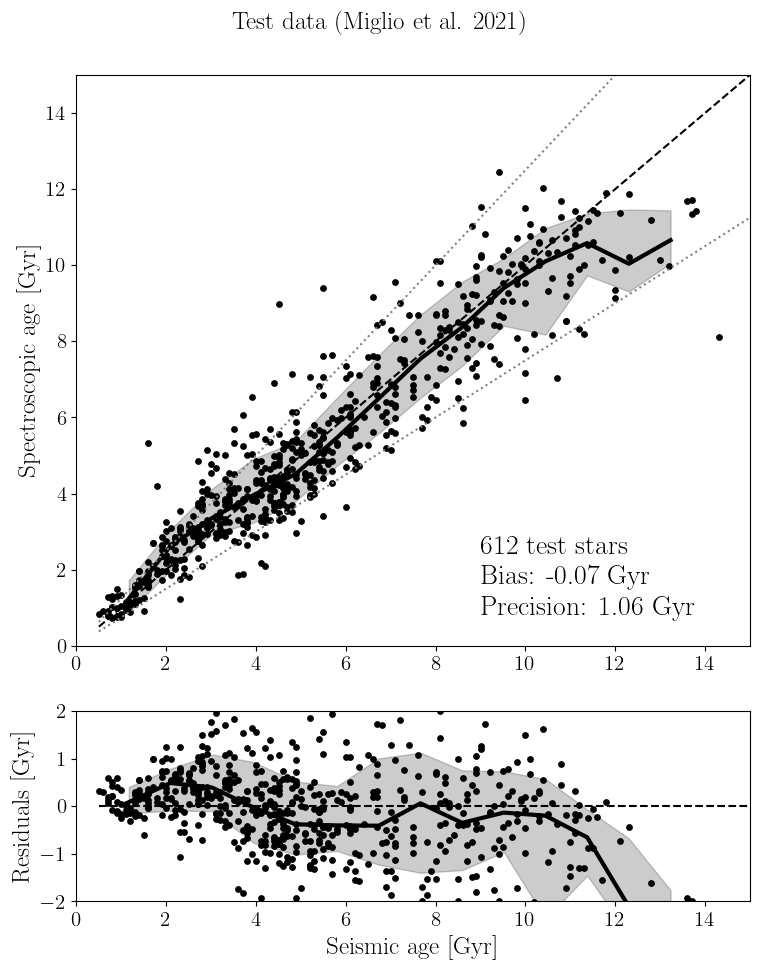

In [24]:
f, (a0, a1) = plt.subplots(2, 1, height_ratios=[3, 1], figsize=(8,10))

# Top panel: predicted age vs. seismic age
plt.axes(a0)
a0.scatter(test_y, pred, c="k", s=15, label="Default model")
overplot_trend(test_y, pred, alpha=0.2, color="k", bins=15)
xx = np.linspace(np.min(test_y), 15, 20)
a0.plot(xx, xx, color = 'k', ls="dashed")
a0.plot(xx, 1.25*xx, color = 'grey', ls="dotted")
a0.plot(xx, 0.75*xx, color = 'grey', ls="dotted")
a0.set_ylabel(r"Spectroscopic age [Gyr]", fontsize=18)
a0.axis([0,15,0,15])

plt.text(9, 2.4, str(len(test_y))+ " test stars", fontsize=20)
plt.text(9, 1.6, "Bias: "+ str(np.round(np.mean(pred-test_y),2))+ " Gyr", fontsize=20)
plt.text(9, 0.8, "Precision: "+ str(np.round(np.std(pred-test_y),2))+ " Gyr", fontsize=20)

# Bottom panel: residuals
plt.axes(a1)
a1.scatter(test_y, pred-test_y, c="k", s=15)
overplot_trend(test_y, pred-test_y, alpha=0.2, color="k", bins=15)
a1.plot(xx, np.zeros(len(xx)), color = 'k', ls="dashed")
a1.set_xlabel(r"Seismic age [Gyr]", fontsize=18)
a1.set_ylabel(r"Residuals [Gyr]", fontsize=18)
a1.axis([0,15,-2, 2])
plt.suptitle("Test data (Miglio et al. 2021)", fontsize=18)
plt.tight_layout()
plt.savefig("../im/predicted_vs_true_testdata.png", dpi=300)

# SHAP

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


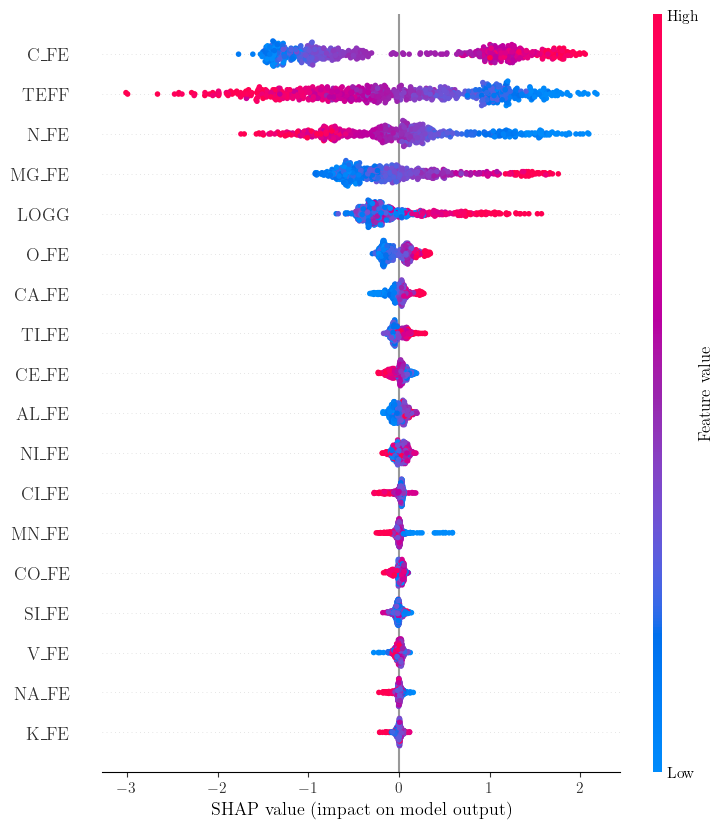

In [25]:
# Fits the explainer
explainer = shap.Explainer(model)
# Calculates the SHAP values - It might take some time
shap_values = explainer(test_X)
shap.summary_plot(shap_values, test_X, show=False)
# Same as
#shap.plots.beeswarm(shap_values)
plt.savefig("../im/shap_beeswarm.png", dpi=300)

# Estimate ages for the APOGEE DR17 data 


Now let's cut out the sample we wish to calculate ages for - and apply the XGBoost model:

In [26]:
# For the method to work, we require good measurements for the main features 
#  {[C/Fe], Teff, [N/Fe], [Mg/Fe], log g} etc... (see above for all the criteria)
sel_big = big[selection].dropna(subset=trainfeatures)

Now filter the necessary columns:

In [27]:
filtered_big = sel_big[trainfeatures].copy()
filtered_big = filtered_big.dropna()
filtered_big = filtered_big.apply(pd.to_numeric, errors='coerce')

print(len(filtered_big), "stars will be used")

193478 stars will be used


Use the model to infer the age:

In [28]:
pred_big = model.predict(filtered_big)

### Save the results as a table

In [29]:
save_big = filtered_big.copy()
save_big["spec_age"+suffix] = np.round(pred_big, 2)
save_big = save_big.drop(columns=trainfeatures)

### Add columns describing the bias and statistical uncertainties 

To do this, we use the comparison with the test sample from above (but now showing the residuals as a function of estimated age):

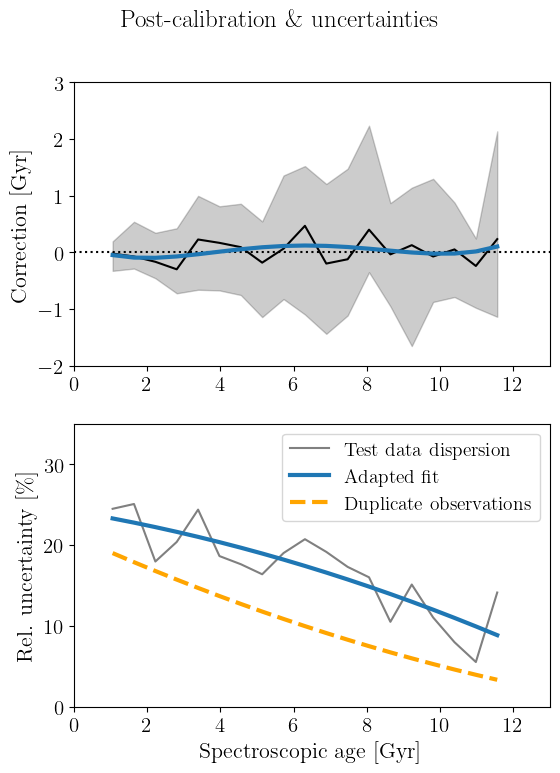

In [30]:
agebins, med, q16, q84, N = running_median(pred, test_y-pred, nbins=20)

f, (a0, a1) = plt.subplots(2, 1, height_ratios=[1, 1], figsize=(6,8))

plt.axes(a0)
plt.hlines(0,0,13, color="k", ls="dotted")
plt.axis([0,13,-2,3])
plt.plot(agebins, med, color="k")
plt.fill_between(agebins, q84, q16, alpha=.2, color="k")
med_fit = np.polyfit(agebins, med, 4)
p1 = np.poly1d(med_fit)
plt.plot(agebins, p1(agebins), lw=3)
plt.ylabel(r"Correction [Gyr]", fontsize=16)

plt.axes(a1)
uncert = 50.*(np.array(q84)-np.array(q16)) / np.array(agebins)
plt.plot(agebins, uncert, color="grey", label="Test data dispersion")
unc_fit = np.polyfit(agebins, uncert, 2)
p2 = np.poly1d(unc_fit)
plt.plot(agebins, p2(agebins), lw=3, label="Adapted fit")
# Add a line for the duplicate-estimated internal uncertainties (see bottom of the notebook)
p3 = np.poly1d([ 0.04341576, -2.03895082, 21.14646907])  
plt.plot(agebins, p3(agebins), lw=3, ls="dashed", c="orange", label="Duplicate observations")
plt.axis([0,13,0,35])
plt.legend(loc="upper right", fontsize=14)
plt.xlabel(r"Spectroscopic age [Gyr]", fontsize=16)
plt.ylabel(r"Rel. uncertainty [\%]", fontsize=16)
plt.suptitle(r"Post-calibration \& uncertainties", fontsize=18)
plt.tight_layout()
plt.savefig("../im/estimating_uncertainties.png", dpi=300)

### Define columns containing the calibrated ages and uncertainties - then save this

In [31]:
def calib_func(x):
    return np.piecewise(x, [x < 0.5, (x >= 0.5) & (x < 12.5), x >= 12.5], [lambda x: 0, lambda x: p1(x), lambda x: 0])

In [32]:
save_big["spec_age"+suffix+"_calib"]  = np.round(pred_big + calib_func(pred_big), 2)
save_big["spec_age"+suffix+"_uncert"] = np.round(0.01 * p2(pred_big) * pred_big, 2)
save_big.to_csv("../data/spec_ages"+suffix+".csv")

### Have a look at the big table

In [33]:
sel_big["spec_age"+suffix]           = np.array(save_big["spec_age"+suffix])
sel_big["spec_age"+suffix+"_calib"]  = np.array(save_big["spec_age"+suffix+"_calib"])
sel_big["spec_age"+suffix+"_uncert"] = np.array(save_big["spec_age"+suffix+"_uncert"])

In [34]:
print("Median age uncertainty:", np.median(sel_big["spec_age"+suffix+"_uncert"]), "Gyr")
print("Median relative age uncertainty:", np.round(100.*np.median(sel_big["spec_age"+suffix+"_uncert"] / sel_big["spec_age"+suffix+"_calib"]),1), "%")

Median age uncertainty: 1.06 Gyr
Median relative age uncertainty: 17.4 %


## Use internal cross-match to get rid of multiple APOGEE_IDs
### and then save the results

First sort by SNREV (APOGEE signal-to-noise ratio):

In [35]:
sel_big = sel_big.sort_values(by='SNREV', ascending=False)
print(np.sum(sel_big.duplicated(subset=['APOGEE_ID'])), "multiple APOGEE_IDs")

14653 multiple APOGEE_IDs


Drop the duplicates:

In [36]:
final_cat = sel_big.drop_duplicates(subset=['APOGEE_ID']).sort_index()
final_cat

,APOGEE_ID,TELESCOPE,FIELD,ALT_ID,RA,DEC,GLON,GLAT,J,J_ERR,...,CU_FE_SPEC,CU_FE_ERR,CU_FE_FLAG,CE_FE,CE_FE_SPEC,CE_FE_ERR,CE_FE_FLAG,spec_age_230414,spec_age_230414_calib,spec_age_230414_uncert
8,b'2M00000133+5721163',b'apo25m',b'NGC7789_btx',b'none',0.005558,57.354549,116.014776,-4.824917,13.261,0.029,...,NaN,0.025131,2,-0.256490,-0.200830,0.132389,0,4.39,4.43,0.87
9,b'2M00000211+6327470',b'apo25m',b'117+01',b'none',0.008802,63.463078,117.227985,1.162167,11.880,0.024,...,NaN,NaN,259,0.194041,0.249701,0.070006,0,3.52,3.50,0.74
10,b'2M00000222+5625359',b'apo25m',b'N7789',b'none',0.009287,56.426662,115.831519,-5.734687,11.982,0.023,...,NaN,0.007840,2,-0.356350,-0.300690,0.131302,0,5.70,5.81,1.04
13,b'2M00000446+5854329',b'apo25m',b'116-04',b'none',0.018603,58.909149,116.330761,-3.302585,12.255,0.023,...,NaN,NaN,259,0.208779,0.264439,0.087975,0,4.06,4.08,0.82
15,b'2M00000506+5656353',b'apo25m',b'NGC7789_btx',b'none',0.021113,56.943142,115.941040,-5.229802,9.317,0.026,...,NaN,0.009253,2,0.009090,0.064750,0.084202,0,3.91,3.91,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733883,b'2M23595553+6339020',b'apo25m',b'117+01',b'none',359.981416,63.650566,117.253198,1.348353,12.551,0.027,...,NaN,NaN,259,0.247312,0.302972,0.139169,0,1.23,1.17,0.29
733890,b'2M23595669+6131251',b'apo25m',b'116+00',b'none',359.986225,61.523659,116.833497,-0.736743,11.698,0.026,...,NaN,0.014083,2,-0.017480,0.038180,0.112270,0,2.74,2.67,0.60
733893,b'2M23595837+5700444',b'apo25m',b'N7789',b'none',359.993224,57.012356,115.939899,-5.158948,12.657,0.026,...,NaN,0.016774,2,-0.035640,0.020020,0.141408,0,3.97,3.98,0.81
733897,b'2M23595886+5726058',b'apo25m',b'116-04',b'none',359.995265,57.434956,116.025359,-4.745011,11.466,0.024,...,NaN,NaN,259,-0.058750,-0.003090,0.072443,0,4.78,4.85,0.93


## Add flags

In [42]:
# 1. star slightly outside the training regime (towards the blue or red side of the main RGB/RC locus)
blue = (final_cat['LOGG'] < -8.6 + 0.0022*final_cat['TEFF'])
red  = (final_cat['LOGG'] > -7 + 0.0022*final_cat['TEFF'])
print(np.sum(blue), "stars a bit too blue")
print(np.sum(red), "stars a bit too red")
# 2. star candidate fast rotator
fast = (final_cat['VSINI'] > 10)
print(np.sum(fast), "fast rotators")
# 3. star young and alpha-rich
yar  = (final_cat["MG_FE"] > 0.2 + 0.0004*(final_cat["spec_age"+suffix+"_calib"] - 3.5)**5)
print(np.sum(yar), "young alpha-rich")

4137 stars a bit too blue
280 stars a bit too red
561 fast rotators
706 young alpha-rich


In [43]:
# Now implement this as a string flag cloumn
final_cat["spec_age"+suffix+"_flag"] = ""
final_cat["spec_age"+suffix+"_flag"][blue] += "BLUER_THAN_TRAINING_SET "
final_cat["spec_age"+suffix+"_flag"][red]  += "REDDER_THAN_TRAINING_SET "
final_cat["spec_age"+suffix+"_flag"][fast] += "HIGH_VSINI"
final_cat["spec_age"+suffix+"_flag"][yar]  += "APPARENTLY_YOUNG_ALPHA_RICH"
# eliminate the final " " in the few relevant cases
final_cat["spec_age"+suffix+"_flag"][final_cat["spec_age"+suffix+"_flag"]=="BLUER_THAN_TRAINING_SET "]="BLUER_THAN_TRAINING_SET"
final_cat["spec_age"+suffix+"_flag"][final_cat["spec_age"+suffix+"_flag"]=="REDDER_THAN_TRAINING_SET "]="REDDER_THAN_TRAINING_SET"


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [44]:
# Visualise this column
np.unique(final_cat["spec_age"+suffix+"_flag"][final_cat["spec_age"+suffix+"_flag"]!=""])
print(len(final_cat["spec_age"+suffix+"_flag"][final_cat["spec_age"+suffix+"_flag"]!=""]), "flagged stars in total")

5383 flagged stars in total


In [45]:
save_table = Table.from_pandas(final_cat[["APOGEE_ID", 
                                          "spec_age"+suffix, "spec_age"+suffix+"_calib", 
                                          "spec_age"+suffix+"_uncert", "spec_age"+suffix+"_flag"]])
save_table.write("../data/spec_ages"+suffix+".fits", overwrite=True)

### Estimate the method's internal uncertainty by looking at the age scatter between duplicate stars:

In [38]:
dups_last  = sel_big[["APOGEE_ID","SNREV","spec_age"+suffix]][sel_big.duplicated(subset=['APOGEE_ID'], keep="first")]
dups_first = sel_big[["APOGEE_ID","SNREV","spec_age"+suffix]][sel_big.duplicated(subset=['APOGEE_ID'], keep="last")]

dups_last  = dups_last.set_index("APOGEE_ID")
dups_first = dups_first.set_index("APOGEE_ID")

dups = dups_first.merge(dups_last, on='APOGEE_ID', suffixes=('_first', '_last'))
dups

,SNREV_first,spec_age_230414_first,SNREV_last,spec_age_230414_last
APOGEE_ID,,,,
b'2M03320729+4526557',3103.083252,5.81,939.933167,5.90
b'2M01240544+8555173',2749.270508,6.66,2195.010254,7.08
b'2M01200992+8445276',2584.540039,0.91,2085.477783,0.86
b'2M03293213+4519275',2500.585938,3.83,714.637085,3.94
b'2M06495343-0421397',2474.801758,0.79,592.658447,0.83
...,...,...,...,...
b'2M21064606+4719419',55.055466,3.17,51.802853,3.85
b'2M06262529-3142032',55.032825,2.13,54.805687,2.18
b'2M10465830-6011426',54.889824,3.05,51.074741,5.02


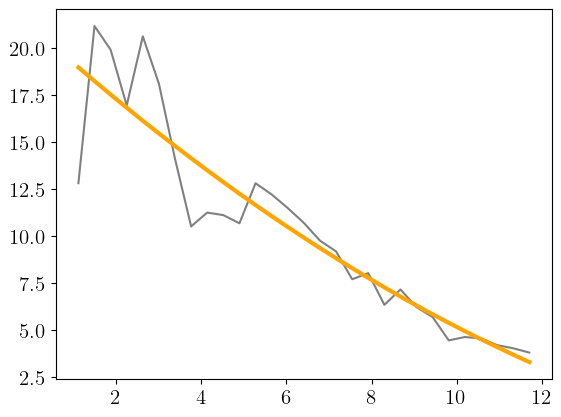

In [39]:
agebins, med, q16, q84, N = running_median(dups["spec_age"+suffix+"_first"], 
                                           dups["spec_age"+suffix+"_last"]-dups["spec_age"+suffix+"_first"], nbins=30)
uncert = 50.*(np.array(q84)-np.array(q16)) / np.array(agebins)
plt.plot(agebins, uncert, color="grey")
unc_fit = np.polyfit(agebins, uncert, 2)
p3 = np.poly1d(unc_fit)
plt.plot(agebins, p3(agebins), lw=3, c="orange")

In [40]:
p3

poly1d([ 0.04346798, -2.03729263, 21.17479793])

## Produce published catalogue: merge this catalogue and the one produced with quantile regression 

In [54]:
from astropy.table import join
qcat = Table.read("../data/spec_ages_230711.fits")
pub  = join(save_table, qcat, keys="APOGEE_ID", join_type="inner")
pub["spec_age_230414"].name        = "spec_age_xgb"
pub["spec_age_230414_calib"].name  = "spec_age_xgb_calib"
pub["spec_age_230414_uncert"].name = "spec_age_xgb_uncert"
pub["spec_age_230414_flag"].name   = "spec_age_xgb_flag"
pub["spec_age_230711"].name        = "spec_age_xgb_quantilereg"
pub["spec_age_230711_calib"].name  = "spec_age_xgb_quantilereg_calib"
pub["spec_age_230711_sigl"].name   = "spec_age_xgb_quantilereg_sigl"
pub["spec_age_230711_sigu"].name   = "spec_age_xgb_quantilereg_sigu"
pub["spec_age_230711_flag"].name   = "spec_age_xgb_quantilereg_flag"
pub

APOGEE_ID,spec_age_xgb,spec_age_xgb_calib,spec_age_xgb_uncert,spec_age_xgb_flag,spec_age_xgb_quantilereg,spec_age_xgb_quantilereg_calib,spec_age_xgb_quantilereg_sigl,spec_age_xgb_quantilereg_sigu,spec_age_xgb_quantilereg_flag
bytes19,float32,float32,float32,str51,float32,float32,float32,float32,bytes52
19140272-1554055,4.48,4.53,0.89,,5.32,5.33,1.54,0.54,--
19155129-1617591,2.63,2.55,0.57,,3.57,3.39,1.29,0.81,--
19170343-1703138,2.4,2.31,0.53,,2.99,2.8,0.9,0.67,--
19180978-1616222,2.12,2.02,0.47,,2.29,2.12,0.47,0.62,--
2M00000133+5721163,4.39,4.43,0.87,,4.49,4.39,1.37,1.09,--
2M00000211+6327470,3.52,3.5,0.74,,3.79,3.63,0.82,0.96,--
...,...,...,...,...,...,...,...,...,...
AP18321365-2326303,7.73,7.81,1.19,,7.59,7.95,1.53,1.65,--
AP18335053-2401242,6.91,7.03,1.15,BLUER_THAN_TRAINING_SET,6.25,6.41,3.51,2.5,BLUER_THAN_TRAINING_SET APPARENTLY_YOUNG_ALPHA_RICH


In [55]:
pub.write("../data/spec_ages_published.fits", overwrite=True)